## **1. Importación de librerias y datos**

In [20]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [8]:
df_unificado = pd.read_excel('DatosCacao_multivariado.xlsx')
df_total = df_unificado.copy()

train_size = int(len(df_unificado) * 0.8)
test_size = len(df_unificado) - train_size

df_unificado = df_unificado.iloc[:-test_size]
df_unificado.drop(columns=["Fecha"], inplace=True)

print(df_unificado.tail())

     COP/kg      TRM  COP/kg (internacional)  Inflacion  COP/kg (futuro)  \
59  23462.8  4116.80                34433.20       5.09         34334.11   
60  22958.2  4102.67                32237.84       5.09         32132.11   
61  23730.8  4168.82                33537.57       5.09         33443.65   
62  23407.5  4192.57                33168.13       5.09         33199.58   
63  23842.2  4274.03                33146.43       5.16         33932.93   

     Produccion  
59  4452.759427  
60  4452.759427  
61  4452.759427  
62  4452.759427  
63  5201.885281  


Debido a que las series no son estacionarias, se hace una diferenciación para volverlas **estacionarias** (como lo pide el modelo VAR).

In [9]:
estacionarias = ["COP/kg","Produccion"]
no_estacionarias = [c for c in df_unificado.columns if c not in estacionarias]
# REVISAR ESTACIONARIEDAD

df_diff = df_unificado.diff().dropna()
df_diff.head()

,COP/kg,TRM,COP/kg (internacional),Inflacion,COP/kg (futuro),Produccion
2,-137.0,-11.55,1010.36,0.00,995.51,0.000000
3,242.9,15.01,807.33,0.00,852.67,0.000000
4,201.6,8.87,540.05,0.00,670.78,0.000000
5,235.0,2.85,1661.87,-0.61,1617.31,-1913.260621
6,604.0,-2.03,2233.24,0.00,2033.85,0.000000


In [10]:
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(series):
    result = adfuller(series.dropna(), autolag='AIC')
    return result[1]  # p-value

def kpss_test(series):
    result = kpss(series.dropna(), regression='c', nlags="auto")
    return result[1]  # p-value

def estacionaridad_tests(df):
    resultados = []
    for col in df.columns:
        try:
            adf_p = adf_test(df[col])
            kpss_p = kpss_test(df[col])
            
            if adf_p < 0.05 and kpss_p > 0.05:
                conclusion = "Estacionaria"
            elif adf_p > 0.05 and kpss_p < 0.05:
                conclusion = "No estacionaria"
            else:
                conclusion = "Inconcluso / revisar"
            
            resultados.append({
                "Variable": col,
                "ADF p-value": round(adf_p, 4),
                "KPSS p-value": round(kpss_p, 4),
                "Conclusión": conclusion
            })
        except Exception as e:
            resultados.append({
                "Variable": col,
                "ADF p-value": None,
                "KPSS p-value": None,
                "Conclusión": f"Error: {e}"
            })
    
    return pd.DataFrame(resultados)


resultados_est = estacionaridad_tests(df_diff)
print(resultados_est)


                 Variable  ADF p-value  KPSS p-value    Conclusión
0                  COP/kg       0.0000           0.1  Estacionaria
1                     TRM       0.0000           0.1  Estacionaria
2  COP/kg (internacional)       0.0000           0.1  Estacionaria
3               Inflacion       0.0000           0.1  Estacionaria
4         COP/kg (futuro)       0.0000           0.1  Estacionaria
5              Produccion       0.0034           0.1  Estacionaria


C:\Users\peter\AppData\Local\Temp\ipykernel_2656\3687467595.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags="auto")
C:\Users\peter\AppData\Local\Temp\ipykernel_2656\3687467595.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags="auto")
C:\Users\peter\AppData\Local\Temp\ipykernel_2656\3687467595.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags="auto")
C:\Users\peter\AppData\Local\Temp\ipykernel_2656\3687467595.py:8: InterpolationWarning: The test statistic is ou

## **2. Aplicación del modelo a los datos**

In [11]:
# Crear el modelo VAR
model = VAR(df_diff)

# Selección del rezago óptimo (AIC, BIC, HQIC, FPE)
lag_order_results = model.select_order(maxlags=5)
print(lag_order_results.summary())

# Elegir el rezago con AIC mínimo para este caso
best_lag = lag_order_results.aic
print(f"Mejor rezago según AIC: {best_lag}")

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       60.82      61.03*  2.593e+26*      60.90*
1       60.86       62.36   2.709e+26       61.44
2       61.23       64.02   4.095e+26       62.31
3       61.48       65.56   5.870e+26       63.07
4       61.18       66.55   5.438e+26       63.27
5      60.79*       67.46   5.544e+26       63.38
-------------------------------------------------
Mejor rezago según AIC: 5


c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [12]:
var_model = model.fit(best_lag)
print(var_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 13, Sep, 2025
Time:                     17:25:05
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    67.4576
Nobs:                     57.0000    HQIC:                   63.3817
Log likelihood:          -2031.81    FPE:                5.54384e+26
AIC:                      60.7908    Det(Omega_mle):     4.09415e+25
--------------------------------------------------------------------
Results for equation COP/kg
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                          -280.797582       411.272396           -0.683           0.495
L1.COP/kg                        -0.109895         0.267356           -0.411           0.681
L1.TRM     

In [13]:
# Número de pasos a predecir
n_steps = test_size

forecast = var_model.forecast(df_diff.values[-best_lag:], steps=n_steps)
forecast_df = pd.DataFrame(forecast, 
                           index=pd.date_range(start=df_diff.index[-1], periods=n_steps+1, freq="W")[1:], 
                           columns=df_diff.columns)

print(forecast_df.head())

                                    COP/kg        TRM  COP/kg (internacional)  \
1970-01-11 00:00:00.000000063  -291.966598  26.450248            -2038.977927   
1970-01-18 00:00:00.000000063 -1198.656618  23.487371             -346.314554   
1970-01-25 00:00:00.000000063   -24.097825  21.813687              393.973685   
1970-02-01 00:00:00.000000063  -713.705116 -57.583350             -250.056081   
1970-02-08 00:00:00.000000063   668.894134  38.134772            -1392.955264   

                               Inflacion  COP/kg (futuro)  Produccion  
1970-01-11 00:00:00.000000063  -0.146018     -2206.163880 -662.256124  
1970-01-18 00:00:00.000000063  -0.043479      -345.231900 -524.041427  
1970-01-25 00:00:00.000000063  -0.027465       714.592388 -373.994006  
1970-02-01 00:00:00.000000063   0.115064      -280.751713  346.591292  
1970-02-08 00:00:00.000000063  -0.069565     -1374.500155 -264.470185  


In [14]:
# Tomamos el último valor real en niveles
last_obs = df_unificado.iloc[-1]

# Reconstruimos los niveles sumando acumulativamente las diferencias
forecast_levels = forecast_df.cumsum() + last_obs.values

forecast_levels = pd.DataFrame(forecast_levels, 
                               index=forecast_df.index, 
                               columns=df_unificado.columns)

print(forecast_levels.head())

                                     COP/kg          TRM  \
1970-01-11 00:00:00.000000063  23550.233402  4300.480248   
1970-01-18 00:00:00.000000063  22351.576784  4323.967619   
1970-01-25 00:00:00.000000063  22327.478958  4345.781306   
1970-02-01 00:00:00.000000063  21613.773842  4288.197956   
1970-02-08 00:00:00.000000063  22282.667976  4326.332728   

                               COP/kg (internacional)  Inflacion  \
1970-01-11 00:00:00.000000063            31107.452073   5.013982   
1970-01-18 00:00:00.000000063            30761.137519   4.970503   
1970-01-25 00:00:00.000000063            31155.111203   4.943038   
1970-02-01 00:00:00.000000063            30905.055122   5.058102   
1970-02-08 00:00:00.000000063            29512.099859   4.988536   

                               COP/kg (futuro)   Produccion  
1970-01-11 00:00:00.000000063     31726.766120  4539.629156  
1970-01-18 00:00:00.000000063     31381.534220  4015.587729  
1970-01-25 00:00:00.000000063     32096.1266

In [21]:
# Calcular métricas de error
mae = mean_absolute_error(df_total['COP/kg'].iloc[-test_size:], forecast_levels['COP/kg'])
rmse = np.sqrt(mean_squared_error(df_total['COP/kg'].iloc[-test_size:], forecast_levels['COP/kg']))

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')

MAE: 5628.6628
RMSE: 6083.5036


## **3. Visualización de los resultados del forecast**

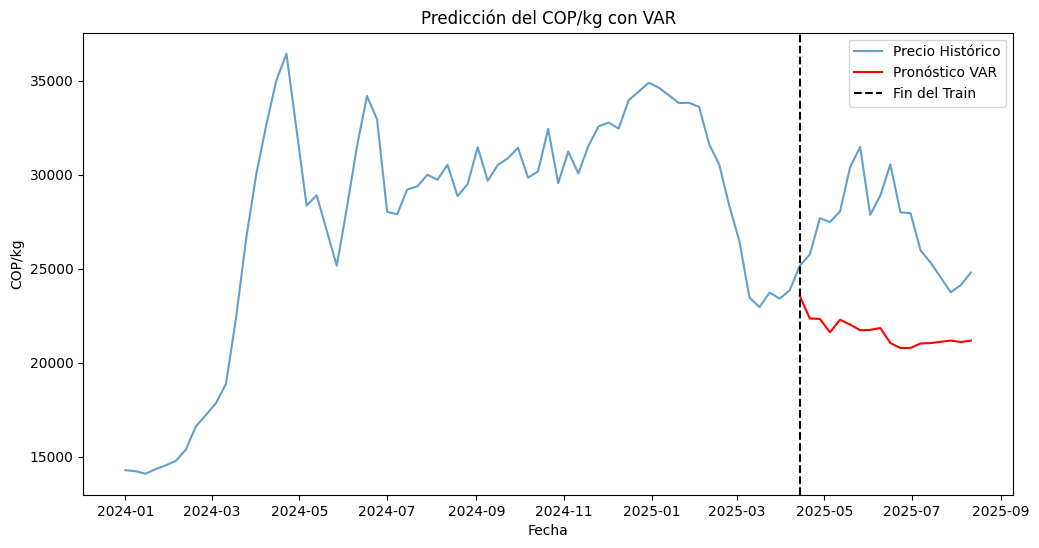

In [18]:
forecast_index = df_total['Fecha'].iloc[train_size:].reset_index(drop=True)
forecast_levels.index = pd.to_datetime(forecast_index)
train_dates = df_total['Fecha'].iloc[:train_size].reset_index(drop=True)

var_name = "COP/kg"  # variable de interés


plt.figure(figsize=(12,6))


plt.plot(df_total['Fecha'], df_total[var_name], label="Precio Histórico", color='C0', alpha=0.7)
plt.plot(forecast_levels.index, forecast_levels[var_name], label="Pronóstico VAR", color="red")
plt.axvline(df_total['Fecha'].iloc[-test_size], color='k', linestyle='--', label='Fin del Train')

plt.title(f"Predicción del {var_name} con VAR")
plt.xlabel("Fecha")
plt.ylabel(var_name)
plt.legend()
plt.show()


## **4. Análisis de impulso-respuesta (IRF)**

In [16]:
target = "COP/kg"   # variable de interés
shock = "Produccion"  # variable que genera el shock

irf.plot(response=target, impulse=shock, orth=False)

NameError: name 'irf' is not defined

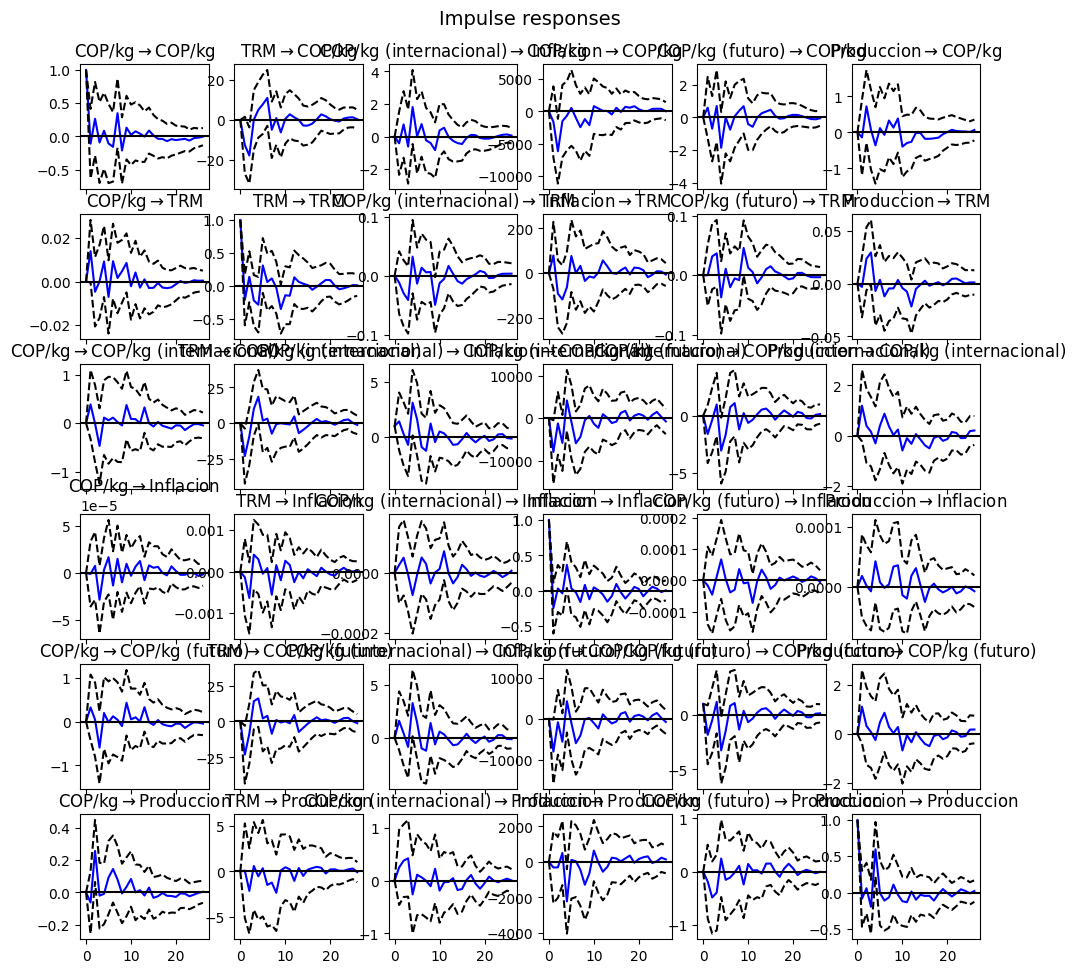

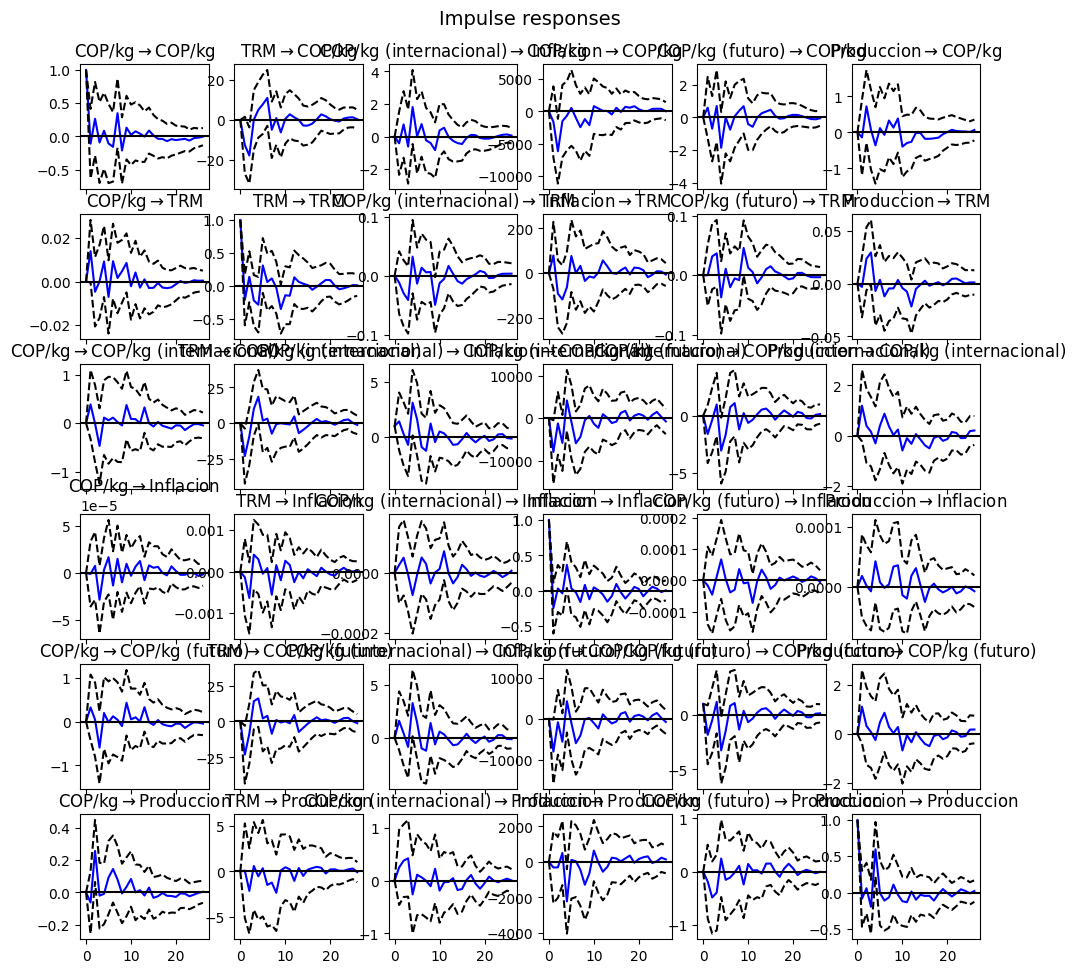

In [ ]:
# Horizonte de predicción del shock
irf = var_model.irf(26)

# Graficar respuesta de todas las variables
irf.plot(orth=False)